In [229]:
import shap
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [230]:
with open("../T23_shap_ml/S01_shap_calc.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_ml = data["shaps"]
    infos_ml = data["infos"]

In [231]:
pd.DataFrame.from_dict(infos_ml)

,model,model_params,test_size,random_state
0,DTR,"{'criterion': 'squared_error', 'splitter': 'ra...",0.3,4
1,EN,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4...",0.3,5
2,GBR,"{'n_estimators': 134, 'learning_rate': 0.02748...",0.3,4
3,KNR,"{'n_neighbors': 36, 'weights': 'distance', 'al...",0.3,5
4,RFR,"{'n_estimators': 60, 'max_depth': 5, 'min_samp...",0.3,5
5,SVR,"{'kernel': 'linear', 'C': 0.012708183589980318...",0.3,5
6,XGBR,"{'n_estimators': 229, 'max_depth': 8, 'learnin...",0.3,5


In [232]:
shap_values_list = []

In [233]:
idxs = [ 2, 4, 6]
for idx in idxs:
    shap_values = shaps_ml[idx]["shap_values"]
    model = shaps_ml[idx]["model"]
    shap_values_list.append(shap_values)
    print(f"Model: {model}")

Model: GBR
Model: RFR
Model: XGBR


In [234]:
with open("../T24_shap_tabPFN/S02_shap_values.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_tabPFN = data["shaps"]


shap_values_list.append(shaps_tabPFN)

In [235]:
# Combine SHAP values
feature_names = shap_values_list[0].feature_names

# Combine values
combined_shape_values = np.vstack([sv.values for sv in shap_values_list])
combined_shape_values.shape

# Combine base values
combined_base_values = np.concatenate([sv.base_values for sv in shap_values_list])
combined_base_values.shape

# Combine data (feature values)
combined_data = np.vstack([sv.data for sv in shap_values_list])
combined_data.shape

(1176, 20)

In [236]:
shap_values = shap.Explanation(
    values=combined_shape_values,
    base_values=combined_base_values,
    data=combined_data,
    feature_names=feature_names,
)

In [237]:
def extract_features(val):
    match1 = re.match(r"^(Fx|Fy|Fz|Mz)__(dwell|weld)", val)
    measure = val
    phase = val
    feature_name_grouped = val
    if match1:
        sp = match1.group(0).split("__")
        measure = sp[0]
        phase = sp[1]
        feature_name_grouped = f"{measure}_{phase}"
    return measure, phase, feature_name_grouped


feat = pd.DataFrame(feature_names, columns=["feature_name"])
feat["measure"], feat["phase"], feat["feature_name_grouped"] = zip(
    *feat["feature_name"].apply(extract_features)
)
feat

,feature_name,measure,phase,feature_name_grouped
0,D,D,D,D
1,Fx__dwell__ar_coefficient__coeff_0__k_10,Fx,dwell,Fx_dwell
2,"Fx__dwell__fft_coefficient__attr_""abs""__coeff_11",Fx,dwell,Fx_dwell
3,"Fx__weld__change_quantiles__f_agg_""var""__isabs...",Fx,weld,Fx_weld
4,"Fx__weld__fft_coefficient__attr_""abs""__coeff_5",Fx,weld,Fx_weld
5,Fx_location,Fx_location,Fx_location,Fx_location
6,"Fy__dwell__fft_coefficient__attr_""abs""__coeff_59",Fy,dwell,Fy_dwell
7,"Fy__dwell__fft_coefficient__attr_""real""__coeff_71",Fy,dwell,Fy_dwell
8,"Fy__weld__change_quantiles__f_agg_""mean""__isab...",Fy,weld,Fy_weld
9,Fy__weld__energy_ratio_by_chunks__num_segments...,Fy,weld,Fy_weld


In [238]:
# Group SHAP values by measure_phase
cbsv = pd.DataFrame(combined_shape_values, columns=feat["feature_name_grouped"])
cbsv = cbsv.T.groupby(by="feature_name_grouped").sum().T
display(cbsv)

feature_name_grouped,D,Fx_dwell,Fx_location,Fx_weld,Fy_dwell,Fy_weld,Fz_dwell,Fz_location,Fz_weld,Mz_dwell,R,W,position
0,-0.004657,-0.043450,-0.099739,0.004135,0.029875,0.052746,0.097289,0.017974,0.050943,0.011142,-0.073703,0.089141,0.553972
1,-0.002549,-0.137389,-0.037059,-0.052325,-0.053406,-0.045648,-0.057839,-0.012969,-0.011169,-0.028843,-0.137339,-0.029771,0.344752
2,-0.003787,-0.017374,0.043101,0.012818,0.050043,0.003642,0.014894,0.021112,-0.031916,-0.007320,0.153245,-0.048380,-0.632888
3,0.003568,-0.036686,-0.102279,-0.009938,0.028198,-0.042342,-0.009250,0.007305,-0.000726,-0.024010,-0.115857,0.113328,0.382681
4,-0.002294,0.028940,-0.047060,0.004197,0.127929,-0.004536,-0.050951,0.005552,0.041526,0.016294,0.198171,-0.009884,0.127397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.026431,0.034868,0.033097,-0.009008,0.068338,-0.041963,-0.013619,-0.034194,0.010152,-0.020166,-0.225549,0.074641,-0.730626
1172,0.039682,0.011130,0.017026,-0.027369,0.028531,0.004854,0.025479,-0.004269,0.007599,0.001006,-0.417073,0.098936,0.273104
1173,0.031988,0.112701,0.027431,-0.024121,0.193033,0.032008,-0.002534,0.014709,0.034139,0.014169,-0.224065,0.135923,0.392642
1174,0.050165,0.013252,-0.021283,-0.035188,0.004990,-0.006186,-0.069651,0.016352,-0.001814,0.009642,-0.247422,0.044635,0.231385


In [239]:
cbdt = pd.DataFrame(combined_data, columns=feat["feature_name_grouped"])
cbdt = cbdt.T.groupby(by="feature_name_grouped").mean().T
display(cbdt)

feature_name_grouped,D,Fx_dwell,Fx_location,Fx_weld,Fy_dwell,Fy_weld,Fz_dwell,Fz_location,Fz_weld,Mz_dwell,R,W,position
0,-1.197824,-0.050329,-1.389219,-0.172194,-0.302552,-0.619530,0.696466,-0.555071,-0.349542,-0.074035,1.255605,1.251840,-0.513150
1,0.000000,0.397068,0.197276,0.709318,0.141734,0.557346,0.184071,0.517862,-0.152815,-0.625615,1.255605,0.023268,-0.009538
2,-1.197824,0.353576,0.356833,0.951907,0.456647,0.023186,-0.208826,1.204769,0.104999,-0.859461,-1.181745,-1.205303,0.997687
3,1.197824,0.166106,-0.265057,0.421381,-0.416974,0.905081,0.067842,-0.673679,-0.064653,-0.349069,1.255605,1.251840,-0.513150
4,-1.197824,-0.022476,-0.188930,0.275675,-0.898051,0.226078,-1.828104,-0.303432,0.186386,1.942120,-1.181745,0.023268,0.494074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,1.277347,0.041051,0.568181,-0.513054,-1.232463,0.955368,-0.191240,1.524944,-0.491109,-1.535566,-0.050953,0.036930,1.012931
1172,1.277347,0.184558,0.114845,0.440236,-0.458330,0.965039,0.099258,-0.397477,-0.106969,-0.324545,1.171912,1.255605,0.020672
1173,0.037569,-1.332547,-0.009964,-0.436240,-0.713594,-0.895881,-0.081969,-0.392532,-0.502177,-0.201957,-0.050953,1.255605,-0.971587
1174,1.277347,-0.176845,-0.300550,-1.596604,-0.035799,-0.652856,-1.227005,-0.085165,-0.124157,0.481560,-0.050953,-1.181745,-1.467716


In [240]:
shap_values_grouped = shap.Explanation(
    values=cbsv.values,
    base_values=combined_base_values,  # unchanged
    data=cbdt.values,
    feature_names=cbsv.columns.tolist(),
)

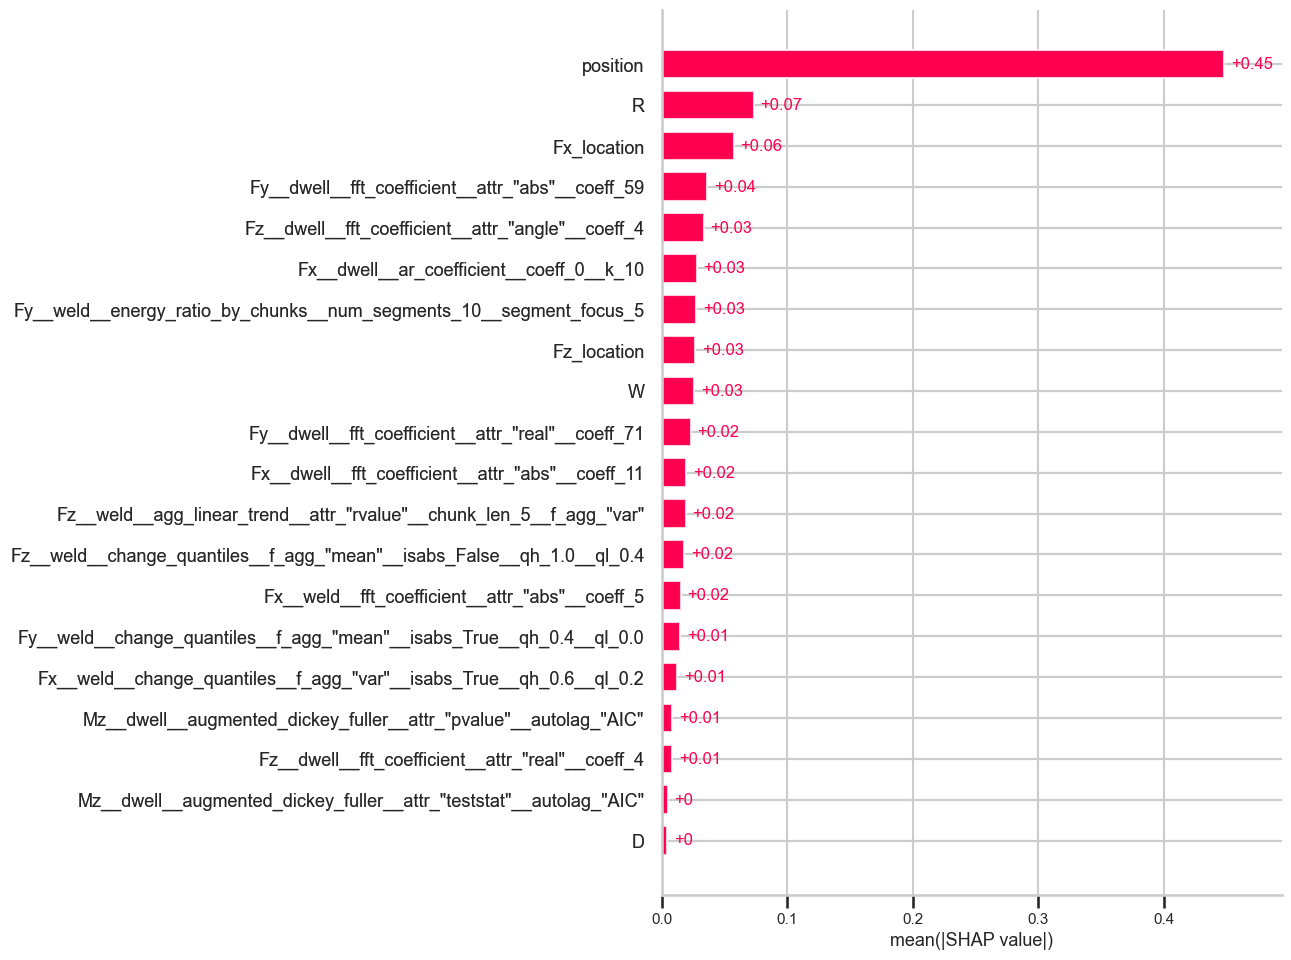

In [241]:
shap.plots.bar(shap_values, max_display=20)

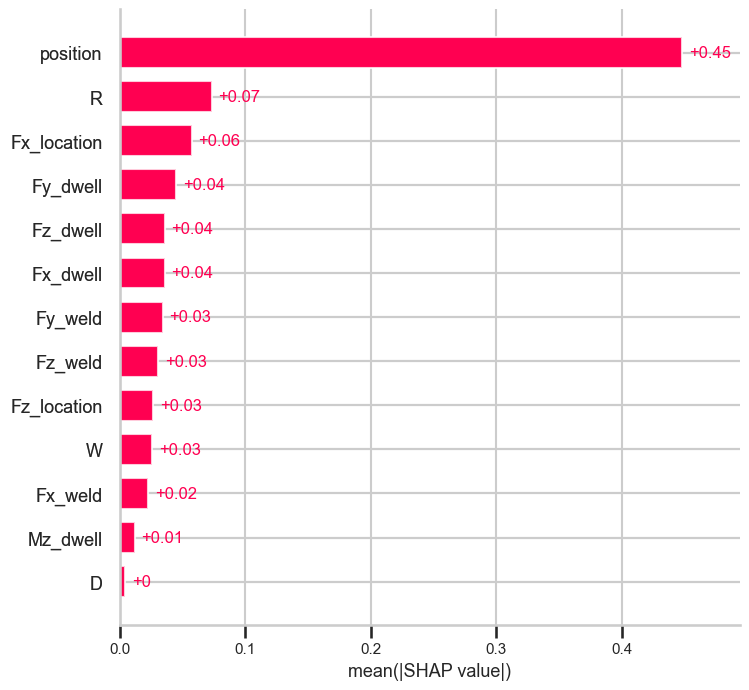

In [242]:
shap.plots.bar(shap_values_grouped, max_display=20)

In [243]:
shap_values_grouped.feature_names

['D',
 'Fx_dwell',
 'Fx_location',
 'Fx_weld',
 'Fy_dwell',
 'Fy_weld',
 'Fz_dwell',
 'Fz_location',
 'Fz_weld',
 'Mz_dwell',
 'R',
 'W',
 'position']

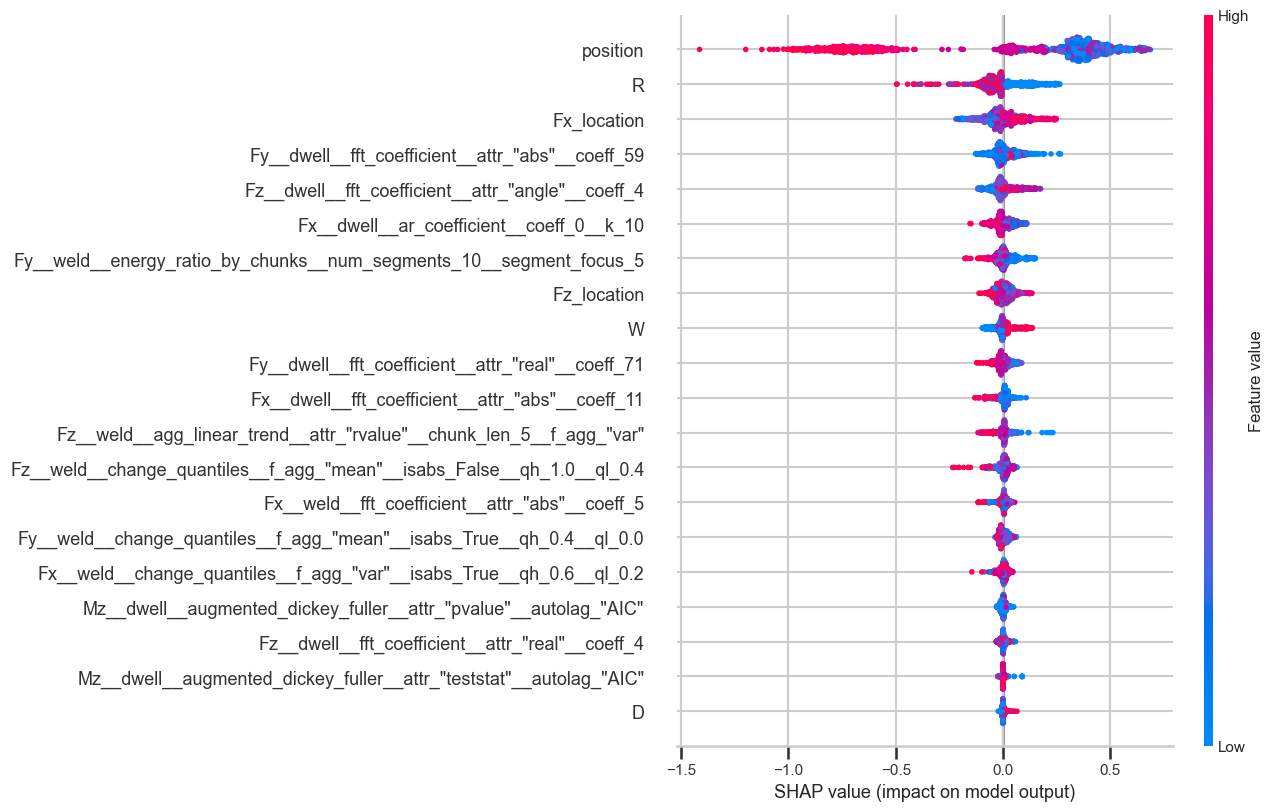

In [244]:
shap.plots.beeswarm(shap_values, max_display=20)

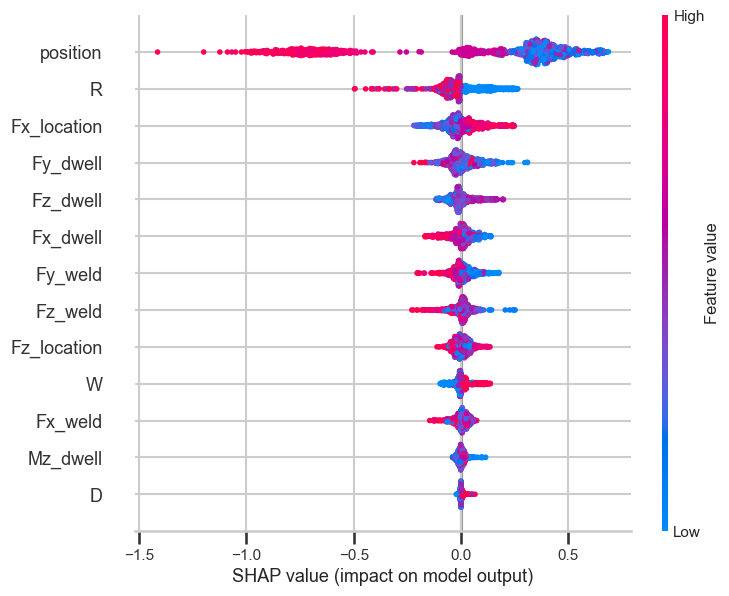

In [245]:
shap.plots.beeswarm(shap_values_grouped, max_display=20)

Text(0.5, 1.0, 'SHAP Value Distribution by Feature (Grouped)')

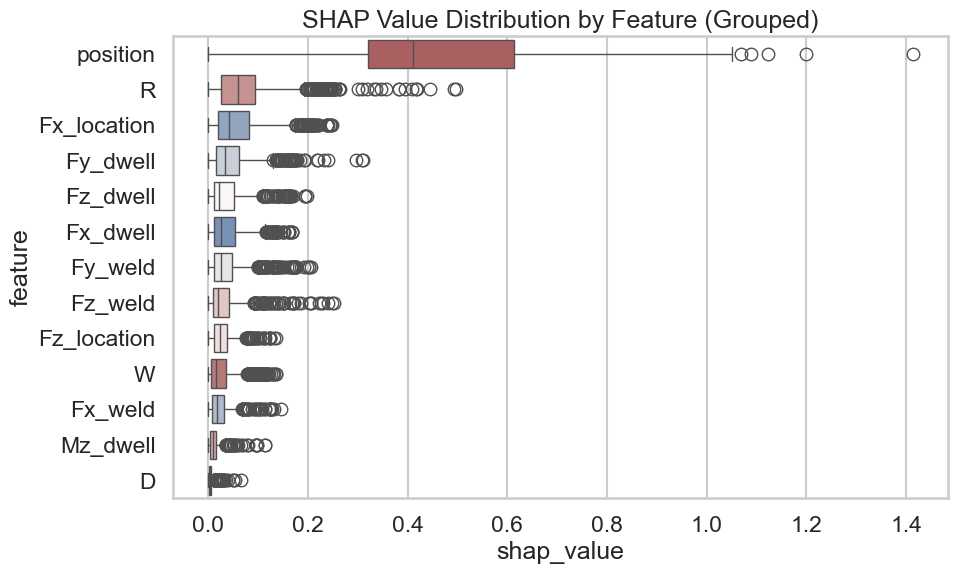

In [246]:
df_shap = pd.DataFrame(
    shap_values_grouped.values, columns=shap_values_grouped.feature_names
)
df_shap_melt = df_shap.melt(var_name="feature", value_name="shap_value")
df_shap_melt_mag = df_shap_melt.copy()
df_shap_melt_mag["shap_value"] = df_shap_melt_mag["shap_value"].abs()
# boxplot
df_plot = df_shap_melt_mag
# sort = df_plot.groupby("feature")["shap_value"].median().sort_values(ascending=False).index
sort = (
    df_plot.groupby("feature")["shap_value"].mean().sort_values(ascending=False).index
)
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="shap_value", y="feature", data=df_plot, order=sort, palette="vlag", hue="feature"
)
plt.title("SHAP Value Distribution by Feature (Grouped)")

## Publication Figure


In [247]:
sns.set_theme(style="whitegrid", context="talk")

['D' 'Fx_dwell' 'Fx_location' 'Fx_weld' 'Fy_dwell' 'Fy_weld' 'Fz_dwell'
 'Fz_location' 'Fz_weld' 'R' 'W' 'position']
['D' 'Fx Dwell' 'Fx Loc Val' 'Fx Weld' 'Fy Dwell' 'Fy Weld' 'Fz Dwell'
 'Fz Loc Val' 'Fz Weld' 'R' 'W' 'Loc Position']


,feature,shap_value
0,D,0.004657
1,D,0.002549
2,D,0.003787
3,D,0.003568
4,D,0.002294
...,...,...
15283,Loc Position,0.730626
15284,Loc Position,0.273104
15285,Loc Position,0.392642
15286,Loc Position,0.231385


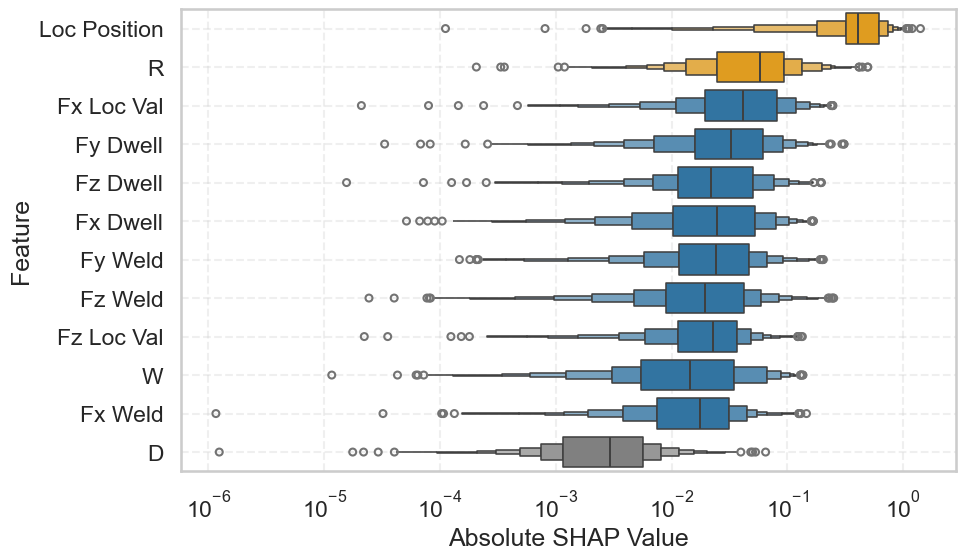

In [248]:
# Prepare DataFrame for final boxplot
dfp1 = pd.DataFrame(
    shap_values_grouped.values, columns=shap_values_grouped.feature_names
)
dfp1 = dfp1.melt(var_name="feature", value_name="shap_value")

# Absolute SHAP values
dfp1["shap_value"] = dfp1["shap_value"].abs()

# Remove Mz_dwell
filt = dfp1["feature"] != "Mz_dwell"
dfp1 = dfp1[filt]

# Map feature names
print(dfp1["feature"].unique())
cols = {
    "D": "D",
    "Fx_dwell": "Fx Dwell",
    "Fx_location": "Fx Loc Val",
    "Fx_weld": "Fx Weld",
    "Fy_dwell": "Fy Dwell",
    "Fy_weld": "Fy Weld",
    "Fz_dwell": "Fz Dwell",
    "Fz_location": "Fz Loc Val",
    "Fz_weld": "Fz Weld",
    "R": "R",
    "W": "W",
    "position": "Loc Position",
}
dfp1["feature"] = dfp1["feature"].map(cols)
print(dfp1["feature"].unique())

# Color Group
feature_colors = {
    "Loc Position": "orange",
    "R": "orange",
    "Fx Dwell": "tab:blue",
    "Fx Loc Val": "tab:blue",
    "Fx Weld": "tab:blue",
    "Fy Dwell": "tab:blue",
    "Fy Weld": "tab:blue",
    "Fz Dwell": "tab:blue",
    "Fz Loc Val": "tab:blue",
    "Fz Weld": "tab:blue",
    "W": "tab:blue",
    "D": "gray",
}

# Final boxplot
display(dfp1)

# Sort features by mean SHAP value
sort = dfp1.groupby("feature")["shap_value"].mean().sort_values(ascending=False).index


plt.figure(figsize=(10, 6))
sns.boxenplot(
    x="shap_value",
    y="feature",
    data=dfp1,
    order=sort,
    palette=feature_colors,
    hue="feature",
)
plt.xlabel("Absolute SHAP Value")
plt.ylabel("Feature")
# log scale for x-axis
plt.xscale("log")
# plt.title("SHAP Value Distribution by Feature (Grouped)")
plt.grid(True, which="major", linestyle="--", alpha=0.3)
plt.savefig("shap_all.png", dpi=300, bbox_inches="tight")